# Table of Contents
 <p><div class="lev1 toc-item"><a href="#General-settings" data-toc-modified-id="General-settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General settings</a></div><div class="lev1 toc-item"><a href="#Initial-exploration" data-toc-modified-id="Initial-exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial exploration</a></div><div class="lev2 toc-item"><a href="#Preprocess-datetimes,-distance-and-speed" data-toc-modified-id="Preprocess-datetimes,-distance-and-speed-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess datetimes, distance and speed</a></div><div class="lev2 toc-item"><a href="#Anomalies" data-toc-modified-id="Anomalies-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Anomalies</a></div><div class="lev3 toc-item"><a href="#Visual-quantile-analysis" data-toc-modified-id="Visual-quantile-analysis-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Visual quantile analysis</a></div><div class="lev2 toc-item"><a href="#General-distributions" data-toc-modified-id="General-distributions-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>General distributions</a></div><div class="lev2 toc-item"><a href="#Duration" data-toc-modified-id="Duration-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Duration</a></div><div class="lev3 toc-item"><a href="#Duration-by-distance" data-toc-modified-id="Duration-by-distance-241"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Duration by distance</a></div><div class="lev2 toc-item"><a href="#Distance" data-toc-modified-id="Distance-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Distance</a></div><div class="lev3 toc-item"><a href="#City-mapping" data-toc-modified-id="City-mapping-251"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>City mapping</a></div><div class="lev1 toc-item"><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></div><div class="lev1 toc-item"><a href="#Classification" data-toc-modified-id="Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Classification</a></div>

# General settings

In [1]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')

from IPython.display import display

In [2]:
drop_pos = ['dropoff_longitude','dropoff_latitude']
pick_pos = ['pickup_longitude', 'pickup_latitude']

lon_pos = ['pickup_longitude', 'dropoff_longitude']
lat_pos = ['pickup_latitude', 'dropoff_latitude']

position = ['pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude']


week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday']

# Initial exploration

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
display(train.head())
display(train.describe().style)

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

A partir da descrição do pandas, podemos notar, observando os campos min, max, e os quartis 1 e 3:
- Existem viagens com 0 passageiros.
- A duração mais curta é de 1 segundo.
- A duração mais longa é > 3000 x Q3.

## Preprocess datetimes, distance and speed

In [4]:
def add_date_specifics(df, column_name, new_prefix):
    df.loc[:,column_name] = pd.to_datetime(df[column_name])
    
    df[new_prefix +'year'] = df[column_name].dt.year
    df[new_prefix +'month'] = df[column_name].dt.month
    df[new_prefix +'yearday'] = df[column_name].dt.dayofyear
    df[new_prefix +'hour'] = df[column_name].dt.hour
    df[new_prefix +'minute'] = df[column_name].dt.minute
    df[new_prefix +'weekday'] = df[column_name].dt.weekday_name
    df[new_prefix +'weeknum'] = df[column_name].dt.weekday
    df[new_prefix +'weekend'] = train['pickup_weekday'].isin(['Saturday', 'Sunday'])

from geopy.distance import great_circle
def add_distances(df):
    """
    Abaixo usamos a aproximação euclideana, ignorando a curvatura da terra,
    por tratarmos de uma unica cidade
    """
    ny_lat = 40.7 # From wikipedia
    R = 6371 # From wikipedia
    deg_rad_ratio = np.pi/180
    conversion = np.array([R*deg_rad_ratio, R*deg_rad_ratio*np.cos(ny_lat*deg_rad_ratio)])
    
    df['line_distance'] = np.sqrt((((df[pick_pos].values - df[drop_pos].values)*conversion)**2).sum(axis=1))
    df['manh_distance'] = np.abs(((df[pick_pos].values - df[drop_pos].values)*conversion)).sum(axis=1)
    #
    #df.apply(lambda x: great_circle(x[pick_pos], x[drop_pos]), axis=1)
    
def add_speed(df):
    """ Velocidade em km/h"""
    df['speed(km/h)'] = 3600*df['line_distance']/df['trip_duration']
    df['manhattan speed(km/h)'] = 3600*df['manh_distance']/df['trip_duration']    

In [5]:
whole = train.append(test)

In [6]:
add_date_specifics(train, 'pickup_datetime', 'pickup_')
add_date_specifics(train, 'dropoff_datetime', 'dropoff_')
add_distances(train)
add_speed(train)
train['log_trip_duration'] = np.log10(train['trip_duration']+1)

add_date_specifics(test, 'pickup_datetime', 'pickup_')
add_distances(test)

## Anomalies and cleaning

In [7]:
train['duration_from_date'] = (train['dropoff_datetime']-train['pickup_datetime']).dt.total_seconds().astype(int)
print('Number of duration inconsistencies:', 
      (train.duration_from_date != train.trip_duration).sum(), 
      '(time provided vs time from datetime diff)')

Number of duration inconsistencies: 0 (time provided vs time from datetime diff)


In [8]:
display('Train:',train.isnull().sum(), 'Test: ', test.isnull().sum())

'Train:'

id                       0
vendor_id                0
pickup_datetime          0
dropoff_datetime         0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
store_and_fwd_flag       0
trip_duration            0
pickup_year              0
pickup_month             0
pickup_yearday           0
pickup_hour              0
pickup_minute            0
pickup_weekday           0
pickup_weeknum           0
pickup_weekend           0
dropoff_year             0
dropoff_month            0
dropoff_yearday          0
dropoff_hour             0
dropoff_minute           0
dropoff_weekday          0
dropoff_weeknum          0
dropoff_weekend          0
line_distance            0
manh_distance            0
speed(km/h)              0
manhattan speed(km/h)    0
log_trip_duration        0
duration_from_date       0
dtype: int64

'Test: '

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
pickup_year           0
pickup_month          0
pickup_yearday        0
pickup_hour           0
pickup_minute         0
pickup_weekday        0
pickup_weeknum        0
pickup_weekend        0
line_distance         0
manh_distance         0
dtype: int64

Podemos ver que não há valores faltando nem no conjunto de treino nem no de teste.

---

##### Limpeza por distância mínima

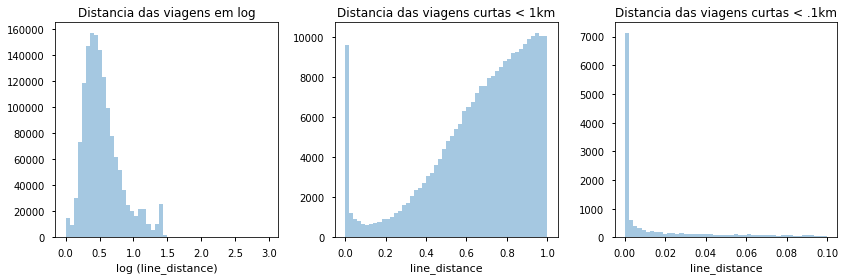

In [9]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.distplot(np.log10(train['line_distance']+1), kde=False); plt.xlabel('log (line_distance)');
plt.title('Distancia das viagens em log')
plt.subplot(1,3,2)
plt.title('Distancia das viagens curtas < 1km')
sns.distplot(train['line_distance'][train['line_distance']<1], kde=False);
plt.subplot(1,3,3)
plt.title('Distancia das viagens curtas < .1km')
sns.distplot(train['line_distance'][train['line_distance']<.1], kde=False);

plt.tight_layout()

Notamos que existem muitas viagens que não mudam de lugar, provavelmente problemas na utilização do dispositivo pelos taxistas.
Removeremos as viagens com tamanho < .1km, que é aproximadamente 1 quarteirão.


---

In [10]:
train = train[train['line_distance']>.1]

---

##### Limpeza por velocidade máxima

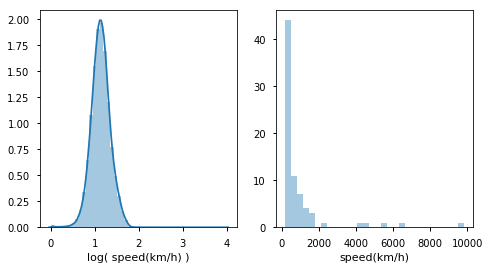

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.distplot(np.log10(train['speed(km/h)']+1)); plt.xlabel('log( speed(km/h) )');

plt.subplot(1,3,2)
ax=sns.distplot(train['speed(km/h)'][train['speed(km/h)'] > 200], kde=False); 

De acordo com [esse site](http://www.speed-limits.com/newyork.htm) e [esse](https://nytrafficticket.com/fastest-road-in-america-and-maximum-speed-limits-in-new-york/), a velocidade maxima em Nova York é 65mph (~104km/h), somente nas rodovias rurais.

Achamos razoável assumir um limite máximo de 200km/h para o nosso dataset, levando em conta que as distâncias medidas são aproximadas. Essa decisão é bastante conservadora, visto que a distância em linha reta tenderá a _subestimar_ as distâncias e as velocidades.

---

In [12]:
train = train[train['speed(km/h)'] < 200]

---

##### Limpeza por localização

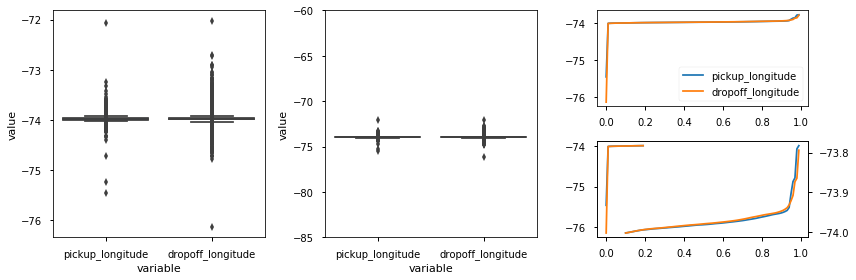

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.boxplot(x='variable', y='value', data=train[lon_pos].melt())
plt.subplot(1,3,2)
sns.boxplot(x='variable', y='value', data=train[lon_pos].melt()); plt.ylim(-85, -60)
ax=plt.subplot(2,3,3)
train[lon_pos][train[lon_pos]>-90].quantile(np.arange(100)/100).plot(ax=ax)
ax=plt.subplot(2,3,6)
train[lon_pos][train[lon_pos]>-90].quantile(np.arange(20)/100).plot(ax=ax,legend=False);
ax=ax.twinx()
train[lon_pos][train[lon_pos]>-90].quantile(np.arange(10,100)/100).plot(ax=ax,legend=False);

plt.tight_layout()

In [24]:
min_lon, max_lon = -74.05, -73.77
min_lat, max_lat = 40.55, 40.93

min_pos = pd.Series(dict(zip(position,[min_lon,min_lat, min_lon, min_lat])))
max_pos = pd.Series(dict(zip(position,[max_lon,max_lat, max_lon, max_lat])))
is_central = ((train[position] > min_pos) & (train[position] < max_pos)).sum(axis=1)==4

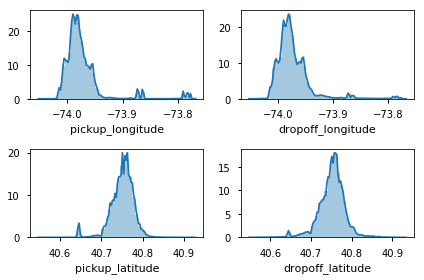

In [25]:
ax = plt.subplot(2,2,1)
sns.distplot(train[is_central]['pickup_longitude'])
ax = plt.subplot(2,2,2)
sns.distplot(train[is_central]['dropoff_longitude'])
ax = plt.subplot(2,2,3)
sns.distplot(train[is_central]['pickup_latitude'])
ax = plt.subplot(2,2,4)
sns.distplot(train[is_central]['dropoff_latitude'])

plt.tight_layout()

---

##### Limpeza por duração máxima

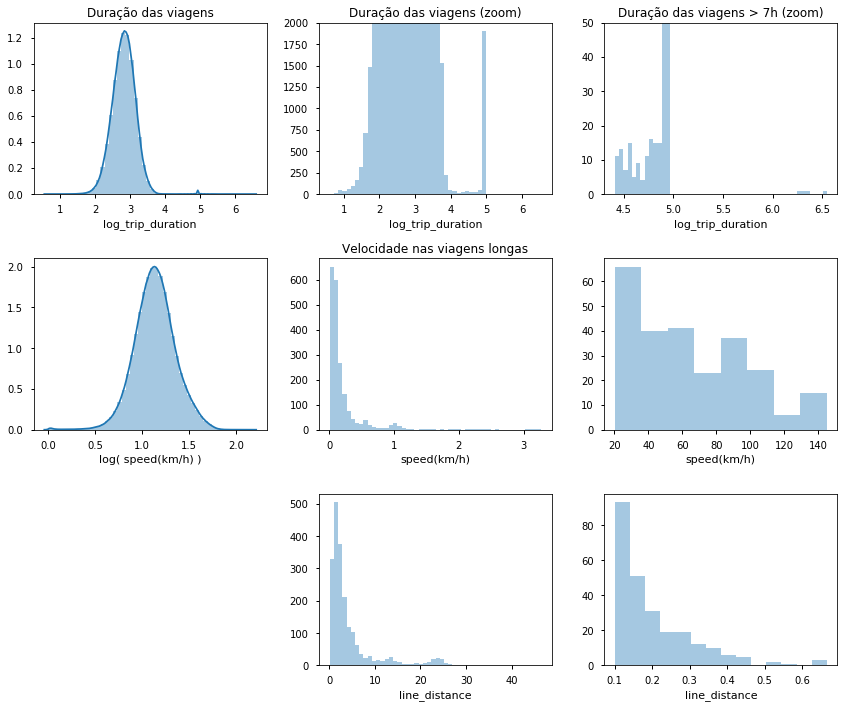

In [472]:
plt.figure(figsize=(12,10))

plt.subplot(3,3,1)
sns.distplot(train['log_trip_duration']); plt.title('Duração das viagens')
plt.subplot(3,3,2)
sns.distplot(train['log_trip_duration'], kde=False); plt.ylim(0, 2000); plt.title('Duração das viagens (zoom)')
plt.subplot(3,3,3)
sns.distplot(train['log_trip_duration'][train['log_trip_duration']>4.4], kde=False); 
plt.title('Duração das viagens > 7h (zoom)'); plt.ylim(0,50);


plt.subplot(3,3,4)
sns.distplot(np.log10(train['speed(km/h)']+1)); plt.xlabel('log( speed(km/h) )');
plt.subplot(3,3,5)
ax=sns.distplot( train['speed(km/h)'][train['log_trip_duration']>4.4], kde=False )
plt.title('Velocidade nas viagens longas')
plt.subplot(3,3,6)
sns.distplot( train['speed(km/h)'][train['trip_duration'] < 20], kde=False ); 
#plt.xlabel('log( speed(km/h) )');

plt.subplot(3,3,8)
sns.distplot( train['line_distance'][train['log_trip_duration']> 4.4], kde=False )
plt.subplot(3,3,9)
sns.distplot( train['line_distance'][train['trip_duration'] < 20], kde=False )

plt.tight_layout()

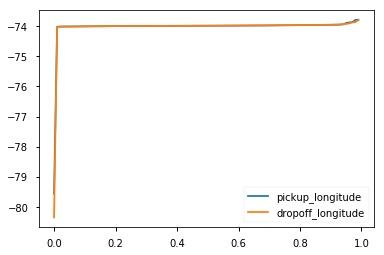

In [271]:
train[lon_pos][train[lon_pos]>-90].quantile(np.arange(100)/100).plot()

### Visual quantile analysis

In [11]:
quants = pd.DataFrame()
for p in np.arange(0,1.001,.001):
    quants = quants.append(train[position].quantile(p))

Text(0.5,1,'')

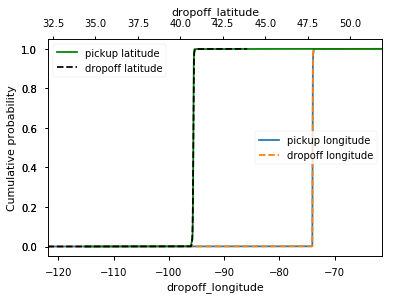

In [12]:
quants[lon_pos].reset_index().set_index(['pickup_longitude'])['index'].plot(label='pickup longitude')
quants[lon_pos].reset_index().set_index(['dropoff_longitude'])['index'].plot(linestyle='--',label='dropoff longitude')
plt.legend(loc='center right')

plt.twiny()
quants[lat_pos].reset_index().set_index(['pickup_latitude'])['index'].plot(color='g',label='pickup latitude')
quants[lat_pos].reset_index().set_index(['dropoff_latitude'])['index'].plot(linestyle='--',color='k', label='dropoff latitude')

plt.ylabel('Cumulative probability')
plt.legend(loc='upper left')
plt.title('')

## Trip duration conditioned

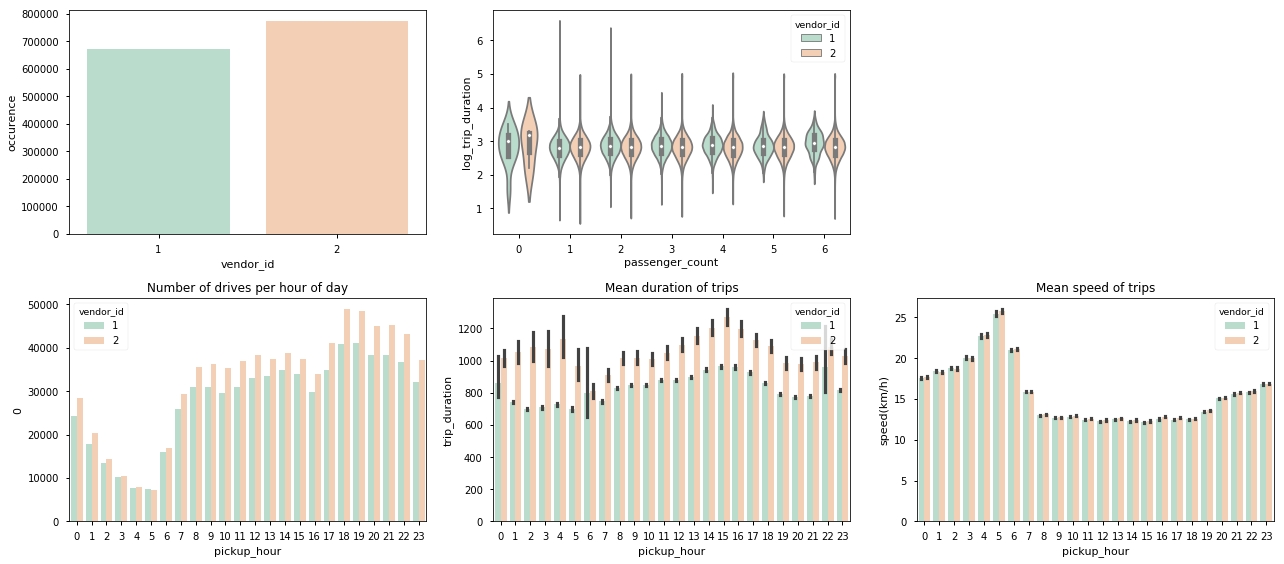

In [504]:
plt.figure(figsize=(18,8))


ax=plt.subplot(2,3,1)
sns.barplot(x='vendor_id', y=0, data= train.groupby('vendor_id').apply(len).reset_index(), palette = 'Pastel2')
plt.ylabel('occurence')

ax=plt.subplot(2,3,2)
passenger_by_cny = train.groupby(['vendor_id', 'passenger_count']).apply(len).reset_index()
sns.violinplot(x='passenger_count', y='log_trip_duration', hue='vendor_id', data=train, ax = ax, palette = 'Pastel2')

ax=plt.subplot2grid((2,3),(1,0))
sns.barplot(x='pickup_hour', y=0, hue='vendor_id', palette = 'Pastel2', 
             data = train.groupby(['vendor_id', 'pickup_hour']).apply(len).reset_index())
plt.title('Number of drives per hour of day')

ax=plt.subplot2grid((2,3),(1,1))
sns.barplot(x='pickup_hour', y='trip_duration', data=train, ax=ax, hue='vendor_id', palette = 'Pastel2')
plt.title('Mean duration of trips')

ax=plt.subplot2grid((2,3),(1,2))
sns.barplot(x='pickup_hour', y='speed(km/h)', data=train, ax=ax, hue='vendor_id', palette = 'Pastel2')
plt.title('Mean speed of trips')

plt.tight_layout()

- A feature vendor_id provavelmente se trata da empresa de taxi.
    - A maior parte 
- A maior parte das viagens de taxi possui apenas 1 passageiro.

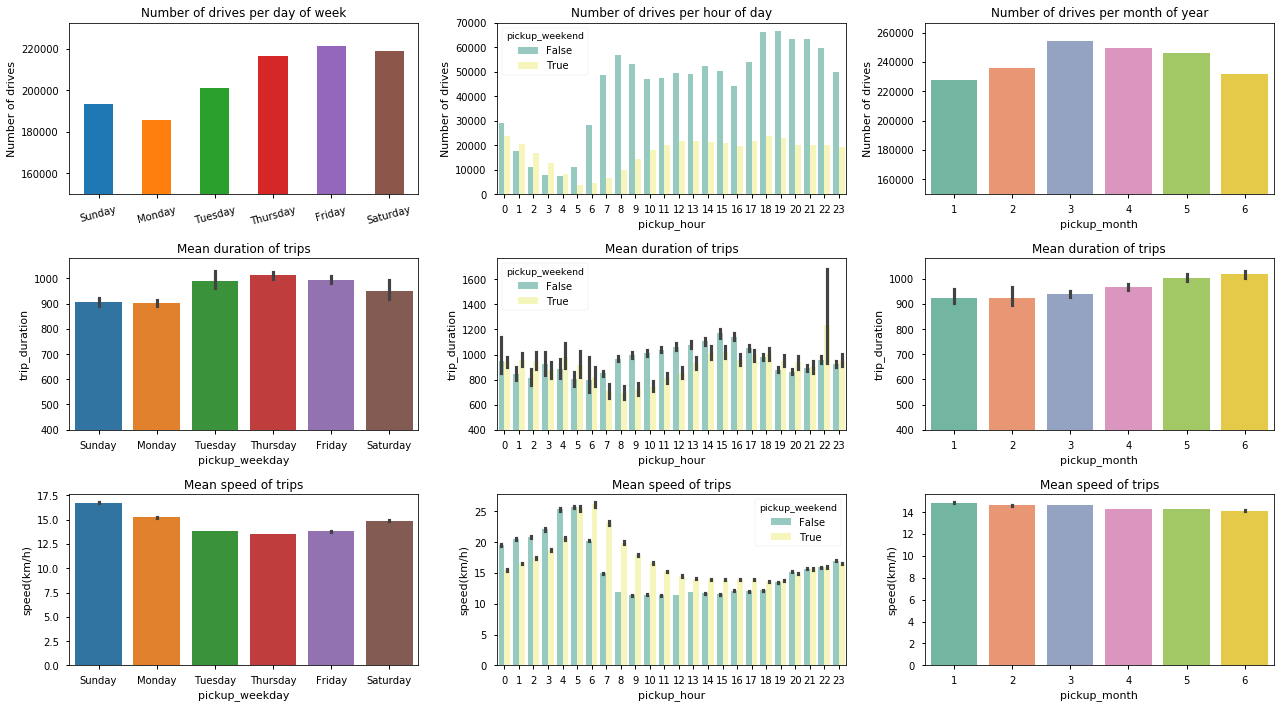

In [475]:
plt.figure(figsize=(18,10))

# Weekday-------------
ax=plt.subplot2grid((3,3),(0,0))
train.pickup_weekday.value_counts()[week].plot.bar(ax=ax, rot=15)
plt.title('Number of drives per day of week'); plt.ylim(150000); plt.ylabel('Number of drives')

ax=plt.subplot2grid((3,3),(1,0))
sns.barplot(x='pickup_weekday', y='trip_duration', data=train, order=week, ax=ax)
plt.title('Mean duration of trips'); plt.ylim(400);

ax=plt.subplot2grid((3,3),(2,0))
sns.barplot(x='pickup_weekday', y='speed(km/h)', data=train, order=week, ax=ax)
plt.title('Mean speed of trips'); 

# Hour -------------
ax=plt.subplot2grid((3,3),(0,1))
sns.barplot(x='pickup_hour', y=0, hue='pickup_weekend', palette = 'Set3', 
             data = train.groupby(['pickup_weekend', 'pickup_hour']).apply(len).reset_index())
plt.title('Number of drives per hour of day'); plt.ylabel('Number of drives')

ax=plt.subplot2grid((3,3),(1,1))
sns.barplot(x='pickup_hour', y='trip_duration', data=train, ax=ax, hue='pickup_weekend', palette = 'Set3')
plt.title('Mean duration of trips'); plt.ylim(400);

ax=plt.subplot2grid((3,3),(2,1))
sns.barplot(x='pickup_hour', y='speed(km/h)', data=train, ax=ax, hue='pickup_weekend', palette = 'Set3')
plt.title('Mean speed of trips');

# Month-------------
ax=plt.subplot2grid((3,3),(0,2))
sns.barplot(x='pickup_month', y=0,
                data=train.groupby('pickup_month').apply(len).reset_index(), palette='Set2')
plt.title('Number of drives per month of year'); plt.ylim(150000); plt.ylabel('Number of drives')

ax = plt.subplot2grid((3,3),(1,2))
sns.barplot(x='pickup_month', y='trip_duration', data=train, ax=ax, palette='Set2')
plt.title('Mean duration of trips'); plt.ylim(400);

ax=plt.subplot2grid((3,3),(2,2))
sns.barplot(x='pickup_month', y='speed(km/h)', data=train, ax=ax, palette='Set2')
plt.title('Mean speed of trips');


plt.tight_layout()

E possivel notar uma diferença clara entre os dias da semana e os fins de semana, entre as 5 da manha e as 18. As viagens costumam ser muito mais lentas nos dias da semana, o que provavelmente se deve ao commute, da ida e volta diaria ao trabalho.

Sem atençao as horas, ainda e possivel ver uma diferença de velocidade nas viagens, mais lenta no meio da semana, e que curiosamente se mantem alta nas segundas feiras, mesmo sendo um dia de trabalho.

# City mapping

In [607]:
def citymap(df, pos = pick_pos, func=len, precision=4000):
    lats = np.arange( int(precision*train[is_central]['dropoff_latitude'].min()),
                      int(precision*train[is_central]['dropoff_latitude'].max())+1)
    lons = np.arange( int(precision*train[is_central]['dropoff_longitude'].min()),
                      int(precision*train[is_central]['dropoff_longitude'].max())+1)
    
    densemap = np.zeros((lons.shape[0], lats.shape[0]))
    local = df.copy()
    local[pos] = local[pos].apply(np.around, decimals=4)
    sparse_vals = local.groupby(pos).apply(func)
    for (lon, lat), count in sparse_vals.iteritems():
        i = int(precision*lon-lons[0])
        j = int(precision*lat-lats[0])
        if i < densemap.shape[0] and j < densemap.shape[1] and i>=0 and j>=0:
            densemap[i,j] = count
    return pd.DataFrame(densemap, index = pd.Index(lons/precision, name='Longitude'), columns=pd.Index(lats/precision, name='Latitude'))

In [609]:
pickmap = np.log10(citymap(train[is_central]) +1)
dropmap = np.log10(citymap(train[is_central], pos = drop_pos) +1)

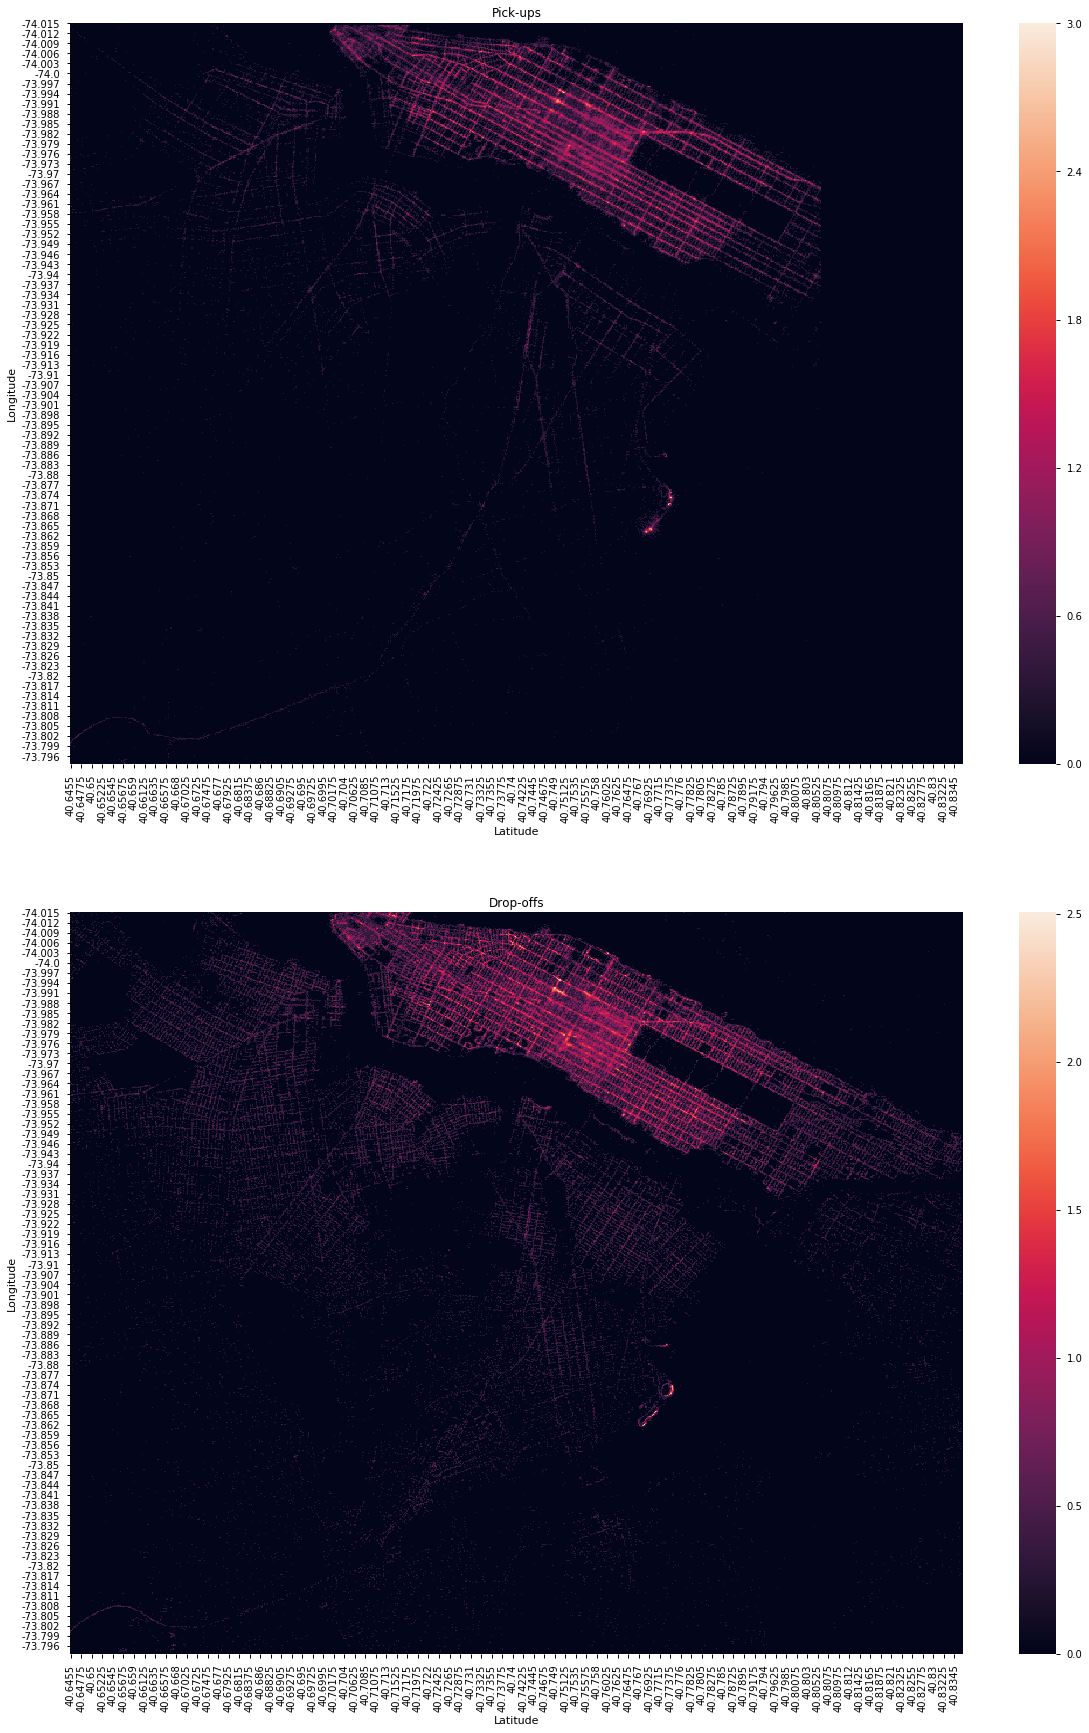

In [610]:
plt.figure(figsize=(20,30))
ax = plt.subplot(2,1,1)
sns.heatmap(pick_plot); plt.title('Pick-ups')
ax = plt.subplot(2,1,2)
sns.heatmap(drop_plot); plt.title('Drop-offs');

Observando os mapas de pickup e dropoff, e possivel notar que existe muito mais consistencia nos pickups, o que e bastante razoavel, levando em conta que os taxistas devem pegar passageiros em vias movimentadas e em seus respectivos pontos de taxi, e provavelmente nao passam muito tempo procurando passageiros em vias pequenas. Essa analise considera que o meio mais comum de pegar taxi, para essas duas empresas em questao, ainda e "presencial", em oposiçao a atraves de aplicativos. 

Outra possibilidade e que os passageiros tenham menor tendencia a pegar taxis na ida para a cidade, talvez pela maior facilidade do transporte publico nessa direçao, e peguem mais comumente na volta para casa, ou em viagens relacionadas a trabalho dentro da propria cidade. Essa hipotese bate com o fato de que o numero de taxis e muito maior nas horas entre 7h e 23h, em uma diferença que ocorre principalmente nos dias da semana, enquanto no fim de semana a quantidade de taxis e menos variavel.

O mais provavel e que ambos os fatores exerçam alguma influencia sobre os dados.

(40.55, 40.93)

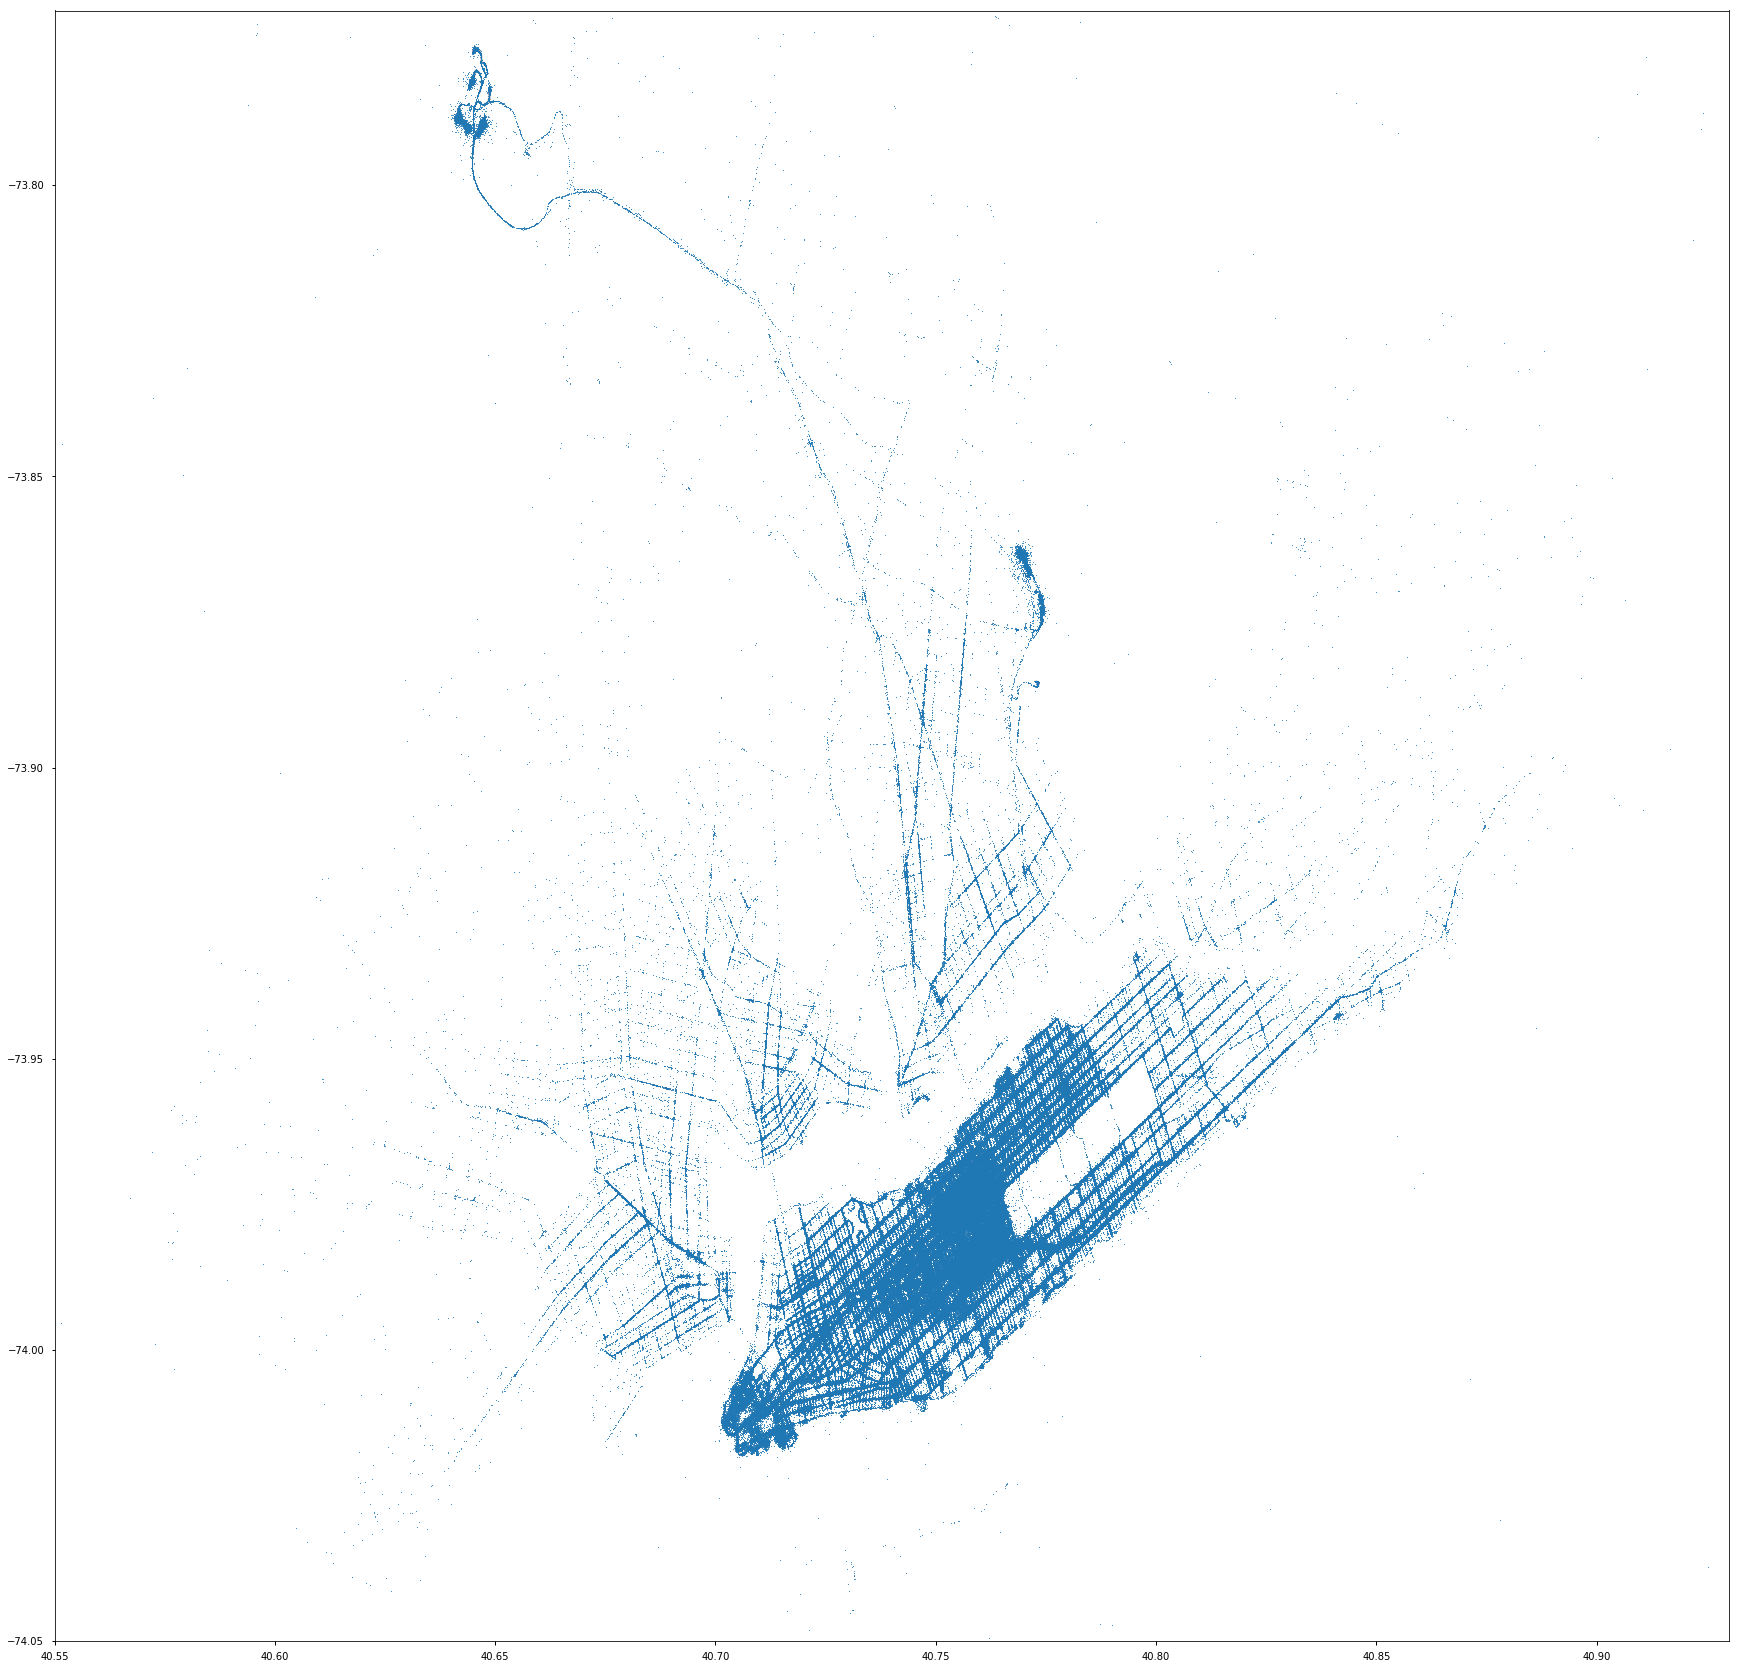

In [623]:
plt.figure(figsize=(30,30))
plt.scatter(train['pickup_latitude'], train['pickup_longitude'], s=.5);
plt.ylim(-74.05, -73.77); plt.xlim(40.55,40.93)

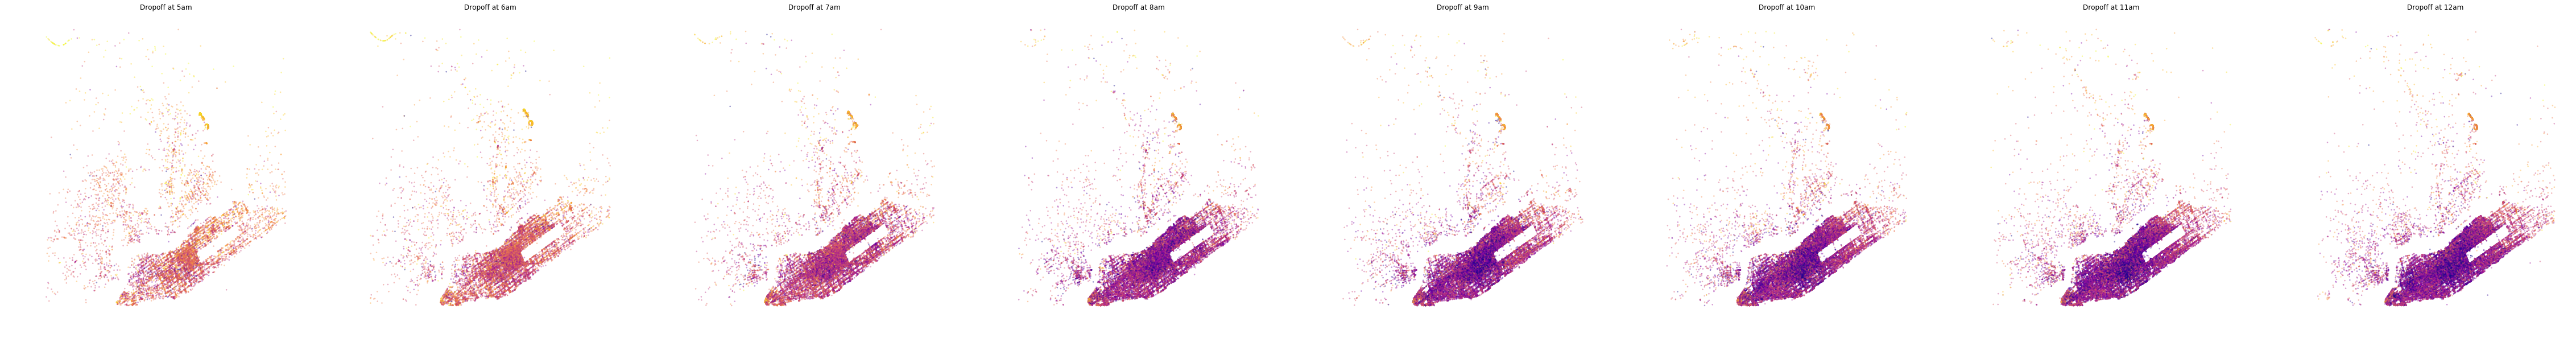

In [595]:
plt.figure(figsize=(80,10))

for i in range(8):
    plt.subplot(1,8,i+1)
    to_plot = (train['dropoff_hour']==i+5) & is_central
    plt.scatter(train[to_plot]['dropoff_latitude'], train[to_plot]['dropoff_longitude'], 
                    s=5, alpha=.4, c=np.log10(train[to_plot]['speed(km/h)']), cmap='plasma', vmin=.7, vmax=1.7)
    plt.title('Dropoff at %dam'%(i+5))
    plt.axis('off')

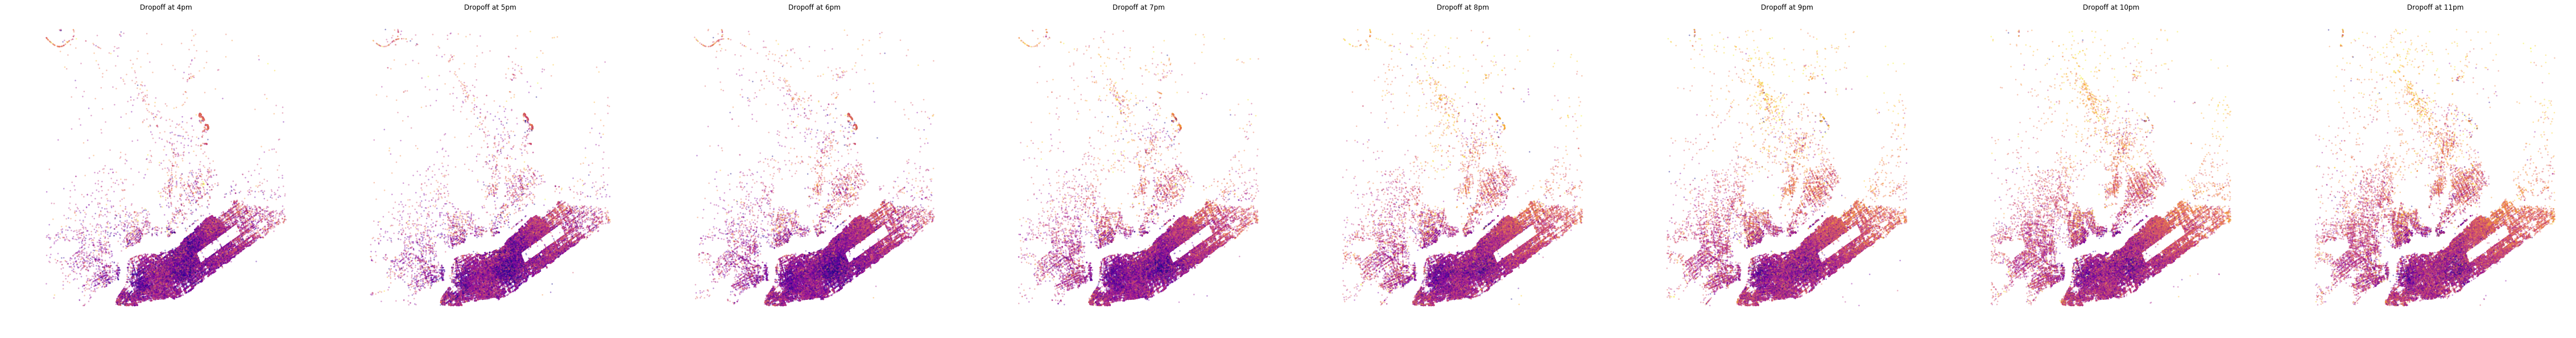

In [596]:
plt.figure(figsize=(80,10))

for i in range(8):
    plt.subplot(1,8,i+1)
    to_plot = (train['dropoff_hour']==i+16) & is_central
    plt.scatter(train[to_plot]['dropoff_latitude'], train[to_plot]['dropoff_longitude'], 
                    s=5, alpha=.4, c=np.log10(train[to_plot]['speed(km/h)']), cmap='plasma', vmin=.7, vmax=1.7)
    plt.title('Dropoff at %dpm'%(i+4))
    plt.axis('off')

E possivel perceber que enquanto a densidade de viagens terminando no centro da cidade parece diminuir um pouco com a chegada da noite, ela aumenta perceptivelmente nos arredores, indicando provavelmente a volta de trabalhadores para suas casas.

A velocidade media das viagens, indicada pela cor dos pontos, indica uma melhora gradual no transito, mais rapida na periferia, especialmente mais distante da cidade entre os aeroportos. As 23h ainda sao lentas as viagens para a parte mais central da cidade.

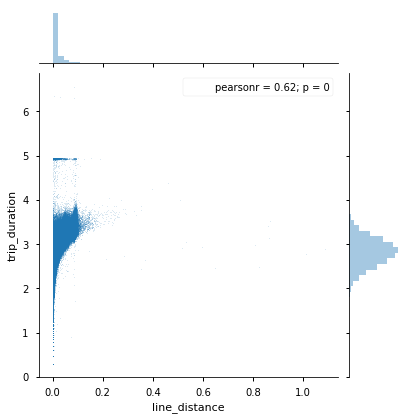

In [258]:
sns.jointplot(x='line_distance', y='trip_duration', data=np.log10(train[['trip_duration', 'line_distance']]+1),s=.02)

### Duration by distance

## Distance

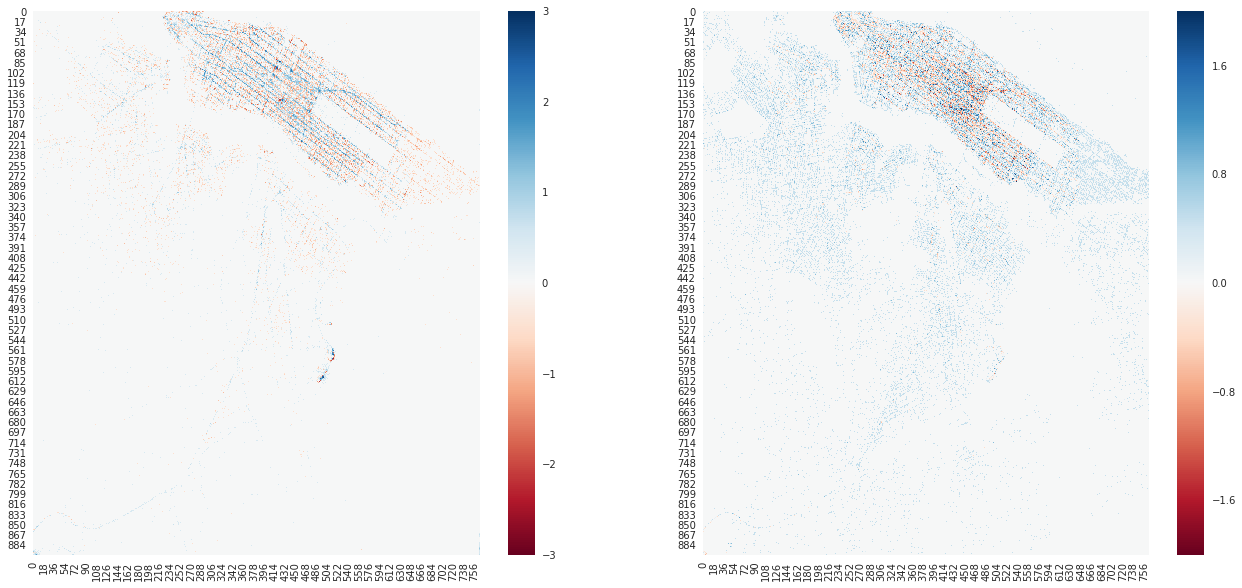

In [538]:
plt.figure(figsize=(22,10))
ax = plt.subplot(1,2,1)
sns.heatmap(np.sign(pickmap - dropmap)* np.log10(abs(pickmap - dropmap+1)), cmap='RdBu', vmin=-3, vmax=3)
ax = plt.subplot(1,2,2)
sns.heatmap(np.sign(pickmap - dropmap)*np.log10(abs(pickmap - dropmap+1)/(dropmap+pickmap+1)), cmap='RdBu', vmin=-2,vmax=2)

# Feature engineering

In [28]:
raw_feat_list = ['vendor_id','pickup_hour','pickup_month','pickup_weeknum', 'store_and_fwd_flag',
                 'pickup_weekend', 'line_distance', 'manh_distance'] + position
onehot_feat_list = ['pickup_hour', 'pickup_month', 'pickup_weekday']

In [23]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)

def one_hot_df(df, feature):    
    onehot = OneHotEncoder(sparse=False)
    dense_X = onehot.fit_transform(df[feature].values.reshape(-1,1))
    return pd.DataFrame( dense_X, columns = ['%s_%d'%(feature, i) for i in onehot.active_features_] )

In [100]:
X = pd.get_dummies(train[onehot_feat_list], columns = onehot_feat_list).join(train[raw_feat_list])
X['store_and_fwd_flag'] = X['store_and_fwd_flag'] == 'Y' 

y = train.log_trip_duration

Xtest = pd.get_dummies(test[onehot_feat_list], columns = onehot_feat_list).join(test[raw_feat_list])
Xtest['store_and_fwd_flag'] = Xtest['store_and_fwd_flag'] == 'Y' 

# Classification

In [74]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import cross_val_score

In [47]:
xgb = XGBRegressor(objective='reg:linear')

In [87]:
%%time
score = cross_val_score(xgb, X.values[100000:200000], y.values[100000:200000], scoring=rmse_score)
print(score)

[ 0.1835375   0.18229776  0.18283213]
CPU times: user 21.1 s, sys: 412 ms, total: 21.5 s
Wall time: 21.5 s


In [89]:
%time xgb.fit(X,y)

CPU times: user 3min 22s, sys: 952 ms, total: 3min 22s
Wall time: 3min 22s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [101]:
ypred = xgb.predict(Xtest)

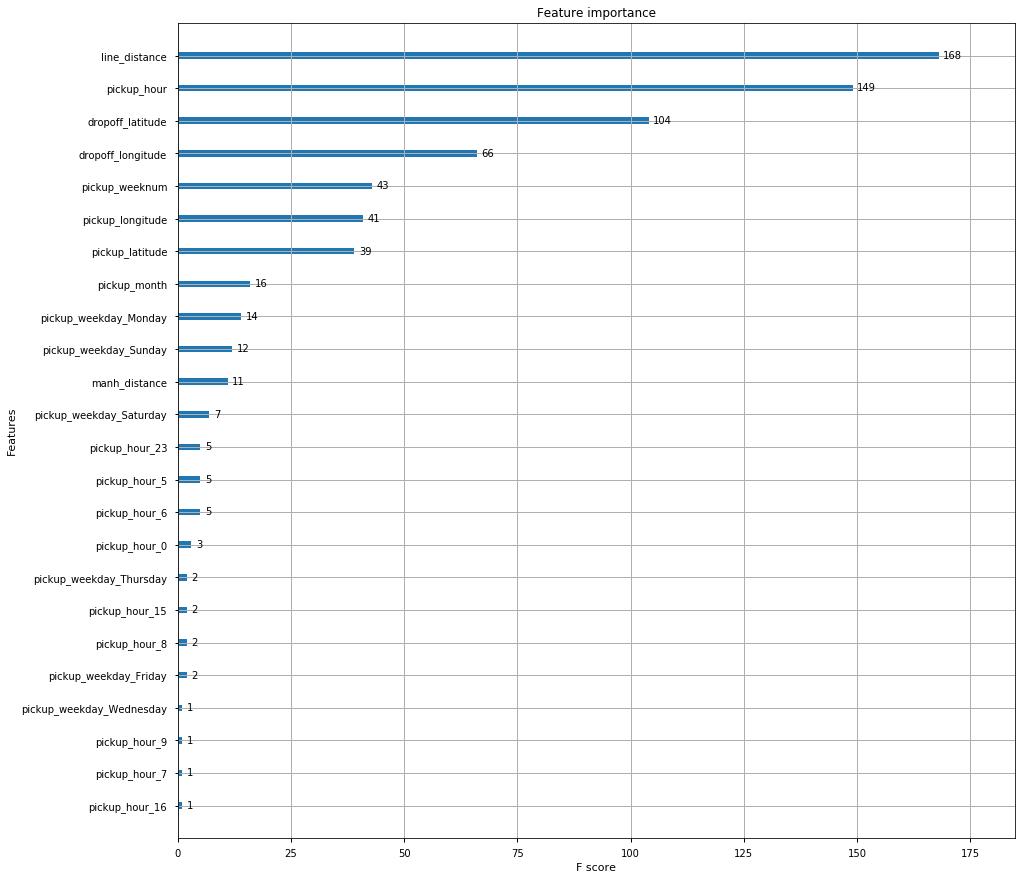

In [90]:
plt.figure(figsize=(15,15))
ax=plt.subplot(1,1,1)
plot_importance(xgb, ax=ax)

## Error metric

In [66]:
def rmsle(y_true,y_pred):
    """
    From https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError
    """
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

def rmse(y_true,y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(y_pred - y_true).mean() ** 0.5

from sklearn.metrics import make_scorer

rmsle_score = make_scorer(rmsle)
rmse_score = make_scorer(rmse)

## Hyperparameter tuning

In [128]:
from skopt import gp_minimize

def optimize(X, y, n_calls=80, n_random_starts=10):
    hyperparameter_space = [(1,15),
                            (0.01,1.),
                            (10,300),
                            (1e-6,10.,"log-uniform"),
                            (1,30),
                            (1e-6,1.,"log-uniform"),
                            (1e-6,1.,"log-uniform"),
                            (1e-2,1.,"log-uniform"),
                            (1e-2,1.,"log-uniform")]
    hyperparameter_names = ['max_depth', 'learning_rate', 'n_estimators', 
                            'gamma', 'min_child_weight', 'reg_alpha', 'reg_lambda', 
                            'colsample_bytree', 'subsample']
    def objective_(params):
        parameters = dict(zip(hyperparameter_names, params))
        print(parameters)
        score = np.mean(np.log(10)*cross_val_score(XGBRegressor(**parameters), X, y, cv=3, scoring=rmse_score))
        return score

    return gp_minimize(objective_, hyperparameter_space, n_calls=n_calls,n_random_starts=n_random_starts, n_jobs=3,verbose=3)

In [129]:
%%time
res = optimize(X, y)

Iteration No: 1 started. Evaluating function at random point.
{'max_depth': 11, 'learning_rate': 0.4739324850107493, 'n_estimators': 290, 'gamma': 4.2811895520041903, 'min_child_weight': 18, 'reg_alpha': 3.3468483228294448e-06, 'reg_lambda': 0.13024497746209746, 'colsample_bytree': 0.036292048691664865, 'subsample': 0.35198233131940876}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 168.5138
Function value obtained: 0.4446
Current minimum: 0.4446
Iteration No: 2 started. Evaluating function at random point.
{'max_depth': 14, 'learning_rate': 0.11826222492800004, 'n_estimators': 244, 'gamma': 0.0069130302053384326, 'min_child_weight': 7, 'reg_alpha': 0.047908749381150535, 'reg_lambda': 8.7162234621082748e-06, 'colsample_bytree': 0.010742862126743264, 'subsample': 0.055651440607191259}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 141.4018
Function value obtained: 0.4910
Current minimum: 0.4446
Iteration No: 3 started. Evaluating function at ran

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 157.3269
Function value obtained: 0.4587
Current minimum: 0.4011
Iteration No: 19 started. Searching for the next optimal point.
{'max_depth': 2, 'learning_rate': 0.021840130390973031, 'n_estimators': 144, 'gamma': 0.19516315397306472, 'min_child_weight': 12, 'reg_alpha': 0.40011060761003631, 'reg_lambda': 0.067885502404654172, 'colsample_bytree': 0.028530827630855897, 'subsample': 0.19762875297591262}
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 67.0918
Function value obtained: 0.7352
Current minimum: 0.4011
Iteration No: 20 started. Searching for the next optimal point.
{'max_depth': 11, 'learning_rate': 0.21476942062372031, 'n_estimators': 287, 'gamma': 2.3074723022921413e-06, 'min_child_weight': 16, 'reg_alpha': 0.5815787682811846, 'reg_lambda': 0.60169547700624582, 'colsample_bytree': 0.78028984074973284, 'subsample': 0.36043975312396048}
Iteration No: 20 ended. Searc

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1663.3281
Function value obtained: 1.8009
Current minimum: 0.3737
Iteration No: 36 started. Searching for the next optimal point.
{'max_depth': 15, 'learning_rate': 0.50374671955137251, 'n_estimators': 269, 'gamma': 0.33589907496272015, 'min_child_weight': 21, 'reg_alpha': 0.0054253412803497384, 'reg_lambda': 0.00099137819324499206, 'colsample_bytree': 0.01862415655940856, 'subsample': 0.026667444861411416}
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 148.8963
Function value obtained: 0.4592
Current minimum: 0.3737
Iteration No: 37 started. Searching for the next optimal point.
{'max_depth': 11, 'learning_rate': 0.49445551813807792, 'n_estimators': 260, 'gamma': 3.1001225759401958, 'min_child_weight': 19, 'reg_alpha': 0.068984765905792791, 'reg_lambda': 4.8861081345731737e-05, 'colsample_bytree': 0.096309072711133425, 'subsample': 0.46413779260398935}
Iteration No: 37 ende

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 159.3447
Function value obtained: 0.4643
Current minimum: 0.3737
Iteration No: 53 started. Searching for the next optimal point.
{'max_depth': 12, 'learning_rate': 0.43321716211904537, 'n_estimators': 289, 'gamma': 0.025584392438432253, 'min_child_weight': 14, 'reg_alpha': 0.44679518925102107, 'reg_lambda': 0.00019120744800385969, 'colsample_bytree': 0.35701337631596902, 'subsample': 0.11444206697460181}
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 1535.7174
Function value obtained: 0.4456
Current minimum: 0.3737
Iteration No: 54 started. Searching for the next optimal point.
{'max_depth': 12, 'learning_rate': 0.2306580079310438, 'n_estimators': 214, 'gamma': 0.000118463237701864, 'min_child_weight': 14, 'reg_alpha': 0.11002962131935076, 'reg_lambda': 0.0021676028850710796, 'colsample_bytree': 0.081452017155650341, 'subsample': 0.17353851895417002}
Iteration No: 54 ended. 

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 315.7106
Function value obtained: 0.4809
Current minimum: 0.3737
Iteration No: 70 started. Searching for the next optimal point.
{'max_depth': 12, 'learning_rate': 0.75005254195411675, 'n_estimators': 262, 'gamma': 0.12296588436775634, 'min_child_weight': 14, 'reg_alpha': 2.5655666983163166e-05, 'reg_lambda': 7.2446692191585236e-05, 'colsample_bytree': 0.061483284236486906, 'subsample': 0.12316933888160052}
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 330.6033
Function value obtained: 0.4830
Current minimum: 0.3737
Iteration No: 71 started. Searching for the next optimal point.
{'max_depth': 12, 'learning_rate': 0.27173553532835976, 'n_estimators': 261, 'gamma': 0.21932517248722397, 'min_child_weight': 14, 'reg_alpha': 2.7811411277529145e-05, 'reg_lambda': 5.2761108188105193e-06, 'colsample_bytree': 0.018586928900150932, 'subsample': 0.05823161069915421}
Iteration No: 71 e

In [75]:
feats_to_one_hot = ['pickup_hour', 'pickup_weeknum']

X = pd.concat([one_hot_df(train, feat) for feat in feats_to_one_hot], axis=1)

pickup_hour_0  pickup_hour_1  pickup_hour_2  pickup_hour_3  \
0                  0.0            0.0            0.0            0.0   
1                  1.0            0.0            0.0            0.0   
2                  0.0            0.0            0.0            0.0   
3                  0.0            0.0            0.0            0.0   
4                  0.0            0.0            0.0            0.0   
5                  0.0            0.0            0.0            0.0   
6                  0.0            0.0            0.0            0.0   
7                  0.0            0.0            0.0            0.0   
8                  0.0            0.0            0.0            0.0   
9                  0.0            0.0            0.0            0.0   
10                 0.0            0.0            0.0            0.0   
11                 0.0            0.0            0.0            0.0   
12                 0.0            0.0            0.0            0.0   
13                 0.0            0.0            0.0            0.0   
14                 1.0            0.0            0.0            0.0   
15                 0.0            0.0            0.0            0.0   
16                 0.0            0.0            0.0            0.0   
17                 0.0            0.0            0.0            0.0   
18                 0.0            0.0            0.0            0.0   
19                 0.0            0.0            0.0            0.0   
20                 0.0            0.0            1.0            0.0   
21                 0.0            0.0            0.0            0.0   
22                 0.0            0.0            0.0            1.0   
23                 0.0            0.0            0.0            0.0   
24                 0.0            0.0            0.0            0.0   
25                 0.0            0.0            0.0            0.0   
26                 0.0            0.0            0.0            0.0   
27                 0.0            0.0            0.0            0.0   
28                 0.0            0.0            0.0            0.0   
29                 0.0            0.0            0.0            0.0   
...                ...            ...            ...            ...   
1458614            0.0            0.0            0.0            0.0   
1458615            0.0            0.0            0.0            0.0   
1458616            0.0            0.0            0.0            0.0   
1458617            0.0            0.0            0.0            0.0   
1458618            0.0            1.0            0.0            0.0   
1458619            0.0            0.0            0.0            0.0   
1458620            0.0            0.0            0.0            0.0   
1458621            0.0            0.0            0.0            0.0   
1458622            0.0            0.0            0.0            0.0   
1458623            0.0            0.0            0.0            0.0   
1458624            0.0            0.0            0.0            0.0   
1458625            0.0            0.0            0.0            0.0   
1458626            0.0            0.0            0.0            0.0   
1458627            0.0            0.0            0.0            0.0   
1458628            0.0            0.0            0.0            1.0   
1458629            0.0            0.0            0.0            0.0   
1458630            0.0            0.0            0.0            1.0   
1458631            0.0            0.0            0.0            0.0   
1458632            0.0            0.0            0.0            0.0   
1458633            0.0            0.0            0.0            0.0   
1458634            0.0            0.0            0.0            0.0   
1458635            0.0            0.0            0.0            0.0   
1458636            0.0            0.0            0.0            0.0   
1458637            0.0            0.0            0.0            0.0   
1458638            1.0           

In [ ]:
best = {'max_depth': 11, 'learning_rate': 0.21476942062372031, 'n_estimators': 287, 
         'gamma': 2.3074723022921413e-06, 'min_child_weight': 16, 'reg_alpha': 0.5815787682811846, 
         'reg_lambda': 0.60169547700624582, 'colsample_bytree': 0.78028984074973284, 'subsample': 0.36043975312396048}

## Submission

In [114]:
sub = pd.DataFrame(test.id)#, index=test.index, columns=['id'])
sub['trip_duration'] = 10**ypred

sub.to_csv('my_sub.csv',index=False)